In [1]:
# Importing Pandas an Numpy Libraries to use on manipulating our Data
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import cross_val_score

import sys
sys.path.append("../")

from Scripts.modeling_pipeline import (
    run_train_pipeline, 
    get_pipeline,
    dvc_get_data)
from Scripts.cleaning import CleanDataFrame
from Scripts.exploration import Analysis
from Scripts.visualization import Plotters
from sklearn.utils import shuffle

import os
import mlflow

In [2]:
df = dvc_get_data(path="Data/ABtwoCampaignEngView.csv", version="v6")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912712 entries, 0 to 912711
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   912712 non-null  int64  
 1   auction_id   912712 non-null  object 
 2   experiment   912712 non-null  object 
 3   date         912712 non-null  object 
 4   hour         912712 non-null  int64  
 5   device_make  912712 non-null  object 
 6   platform_os  912712 non-null  int64  
 7   browser      912712 non-null  int64  
 8   yes          912712 non-null  float64
 9   no           912712 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 69.6+ MB


It doesn't look like there are any missing entries. But let's confirm this.

In [4]:
cleaner = CleanDataFrame()
cleaner.percent_missing(df)

The dataset contains 0.0 % missing values.


Next, let's see if there are duplicated rows using the auction_id

In [5]:
display(df[df.duplicated('auction_id', False)].head())
print("Duplicated rows:", df[df.duplicated('auction_id', False)].shape[0])

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
153,611695,415c4ac6-cc80-4f84-856c-9e821ba37fa7,control,<built-in method date of Timestamp object at 0...,19,Apple,101,7,0.0,0.0
180,105739,0b4b114a-7be3-435e-beb5-76cbd29ae329,control,<built-in method date of Timestamp object at 0...,8,Apple,101,15,0.0,1.0
336,1752177,bb84fd6a-7353-4157-9f84-e30159e38b8e,control,<built-in method date of Timestamp object at 0...,6,Apple,101,15,0.0,0.0
509,460884,3144fd93-dc96-424c-8ba8-6f24078d3c09,control,<built-in method date of Timestamp object at 0...,22,Apple,171,7,0.0,0.0
566,303927,20715f98-69b8-41aa-ae78-5ab1b65682a2,control,<built-in method date of Timestamp object at 0...,20,Apple,101,7,0.0,0.0


Duplicated rows: 39358


There are indeed duplicated rows. There is also a problem with the date column. 
It looks like they forgot to call a string to datetime format converter method.
Now, we just have the method signature. 

In the next step I will remove the columns I won't need. I will also remove users that didn't reponde

1. Unnamed: 0
2. auction_id
3. date
4. no

In [6]:
clean_df = cleaner.drop_duplicates(df)
clean_df = cleaner.drop_unresponsive(clean_df)
clean_df = cleaner.drop_columns(df=clean_df,
                columns=['Unnamed: 0', 'auction_id', 'date', 'no'])
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96617 entries, 80 to 912706
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   experiment   96617 non-null  object 
 1   hour         96617 non-null  int64  
 2   device_make  96617 non-null  object 
 3   platform_os  96617 non-null  int64  
 4   browser      96617 non-null  int64  
 5   yes          96617 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 5.2+ MB


Let's look at the unique entries for the device_make, platform_os and browser column.
This helps me choose how to encode them for my models.

In [7]:
unique_device_make = clean_df.device_make.unique().shape
unique_browsers = clean_df.browser.unique().shape
unique_os = clean_df.platform_os.unique().shape

print(f"unique_device_make: {unique_device_make[0]}")
print(f"unique_browsers: {unique_browsers[0]}")
print(f"unique_os: {unique_os[0]}")

unique_device_make: 89
unique_browsers: 7
unique_os: 44


In [8]:
analyzer = Analysis()

In [9]:
analyzer.get_univariate_analysis(clean_df)

,count,mean,std,min,25%,50%,75%,max,mode,CoV,skew,kurtosis,iqr,missing_counts
hour,96617.0,10.063571,7.387838,0.0,3.0,10.0,17.0,23.0,2.0,0.734117,0.178519,-1.415354,14.0,0
platform_os,96617.0,117.050964,27.770550,101.0,101.0,101.0,145.0,180.0,101.0,0.237252,1.219523,-0.359402,44.0,0
browser,96617.0,7.930250,3.549317,1.0,6.0,6.0,7.0,15.0,6.0,0.447567,1.467704,0.205009,1.0,0
yes,96617.0,0.875560,0.330084,0.0,1.0,1.0,1.0,1.0,1.0,0.376998,-2.275588,3.178367,0.0,0


In [10]:
plotters = Plotters(w=6, h=4)


6     64421
15    19293
7     12770
5        79
12       34
1        11
8         9
Name: browser, dtype: int64

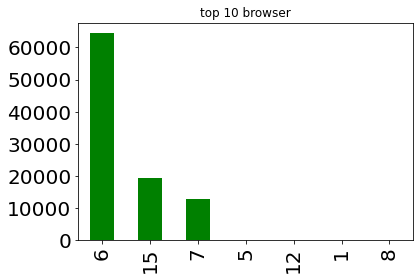

In [11]:
plotters.plot_top_n_counts(clean_df, 'browser', top_n=10, title="top 10 browser")


101    71855
162     8605
156     4232
178     3508
155     3180
179     1135
174      783
175      646
173      374
171      374
Name: platform_os, dtype: int64

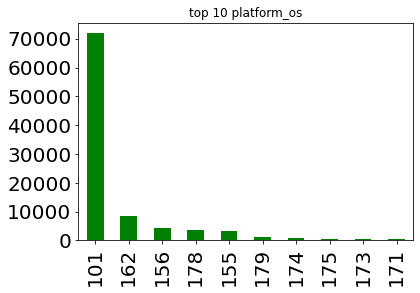

In [12]:
plotters.plot_top_n_counts(clean_df, 'platform_os', top_n=10, title="top 10 platform_os")


Samsung     46525
Apple       23065
Google      20908
Motorola     2285
LG           1619
OnePlus       684
Amazon        287
TCL           274
HTC            90
Xiaomi         69
Name: device_make, dtype: int64

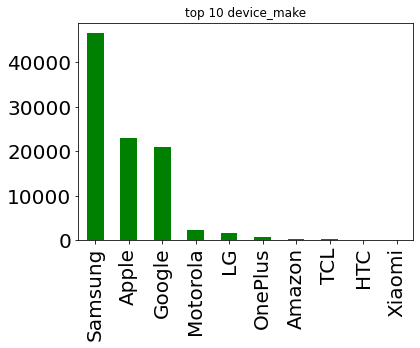

In [13]:
plotters.plot_top_n_counts(clean_df, 'device_make', top_n=10, title="top 10 device_make")

In [14]:
clean_df.experiment.value_counts()

exposed    78973
control    17644
Name: experiment, dtype: int64

<AxesSubplot:ylabel='experiment'>

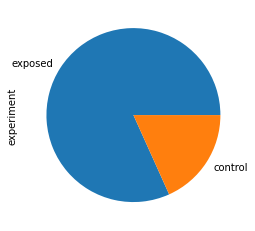

In [15]:
clean_df.experiment.value_counts().plot.pie()

In [16]:
clean_df.experiment.value_counts().values[0] / clean_df.experiment.value_counts().values[1]

4.475912491498526

This might cause problems. We have almost 5 times as much samples for exposed users as we have from control group.

In [17]:
exposed = clean_df[clean_df['experiment']=='exposed'].reset_index(drop=True)
control = clean_df[clean_df['experiment']=='control'].reset_index(drop=True)
balanced_df = control.append(exposed.loc[:len(control), :])

balanced_df = shuffle(balanced_df).reset_index(drop=True)



/tmp/ipykernel_25230/2395147701.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = control.append(exposed.loc[:len(control), :])


In [18]:
x = balanced_df.drop(columns=['yes'])
y = balanced_df['yes'].values


In [19]:
# x = clean_df.drop(columns=['yes'])
# y = clean_df['yes'].values


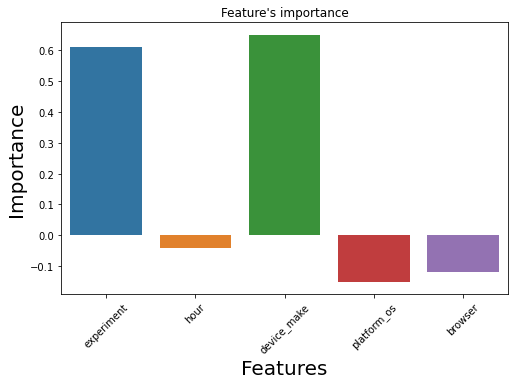

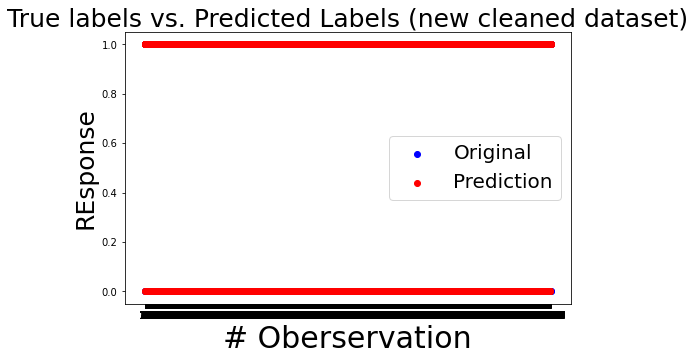

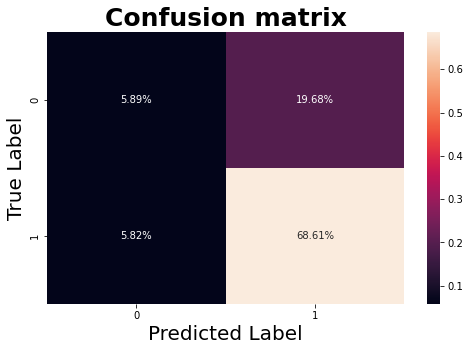

{'accuracy': 0.75, 'precision': 0.78, 'recall': 0.92, 'entropy': 0.48, 'true_pos': 624, 'true_neg': 7264, 'false_pos': 2083, 'false_neg': 616}
{'experiment': 0.61, 'hour': -0.04, 'device_make': 0.65, 'platform_os': -0.15, 'browser': -0.12}
Saving figures


Successfully registered model 'new cleaned dataset_logistic regression_Sun-May-22-16:42:15-2022'.
2022/05/22 16:42:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: new cleaned dataset_logistic regression_Sun-May-22-16:42:15-2022, version 1
Created version '1' of model 'new cleaned dataset_logistic regression_Sun-May-22-16:42:15-2022'.


Run - logistic regression is logged to Experiment - new cleaned dataset


In [21]:
model = LogisticRegression()
run_train_pipeline(model, x, y, 
                experiment_name='new cleaned dataset',
                run_name='logistic regression')

mlflow.end_run()

Maybe the data is not balanced regarding the responses

In [22]:
balanced_df.yes.value_counts()

1.0    26322
0.0     8967
Name: yes, dtype: int64

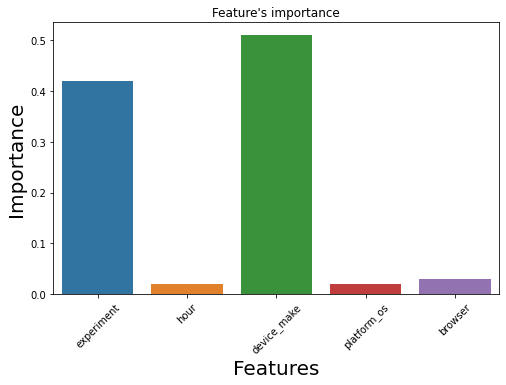

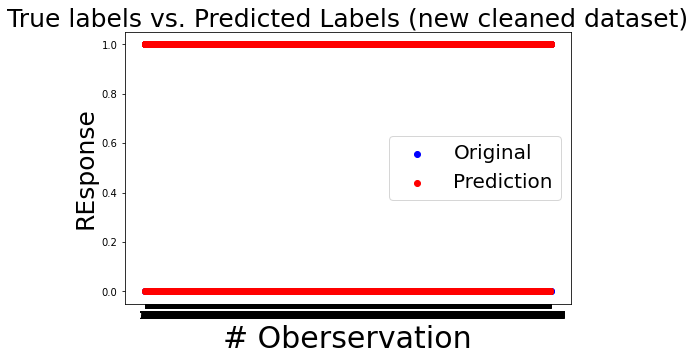

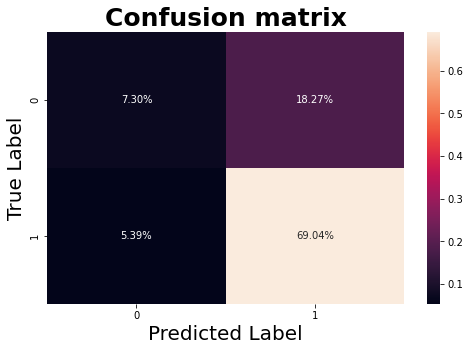

{'accuracy': 0.76, 'precision': 0.79, 'recall': 0.93, 'entropy': 0.48, 'true_pos': 773, 'true_neg': 7309, 'false_pos': 1934, 'false_neg': 571}
{'experiment': 0.42, 'hour': 0.02, 'device_make': 0.51, 'platform_os': 0.02, 'browser': 0.03}
Saving figures


Successfully registered model 'new cleaned dataset_XGBRFClassifier_Sun-May-22-16:48:50-2022'.
2022/05/22 16:49:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: new cleaned dataset_XGBRFClassifier_Sun-May-22-16:48:50-2022, version 1
Created version '1' of model 'new cleaned dataset_XGBRFClassifier_Sun-May-22-16:48:50-2022'.


Run - XGBRFClassifier is logged to Experiment - new cleaned dataset


In [23]:
mlflow.end_run()
model = XGBRFClassifier()
run_train_pipeline(model, x, y, 
                experiment_name='new cleaned dataset',
                run_name='XGBRFClassifier')

mlflow.end_run()

In [24]:
x = clean_df.drop(columns=['yes'])
y = clean_df['yes'].values


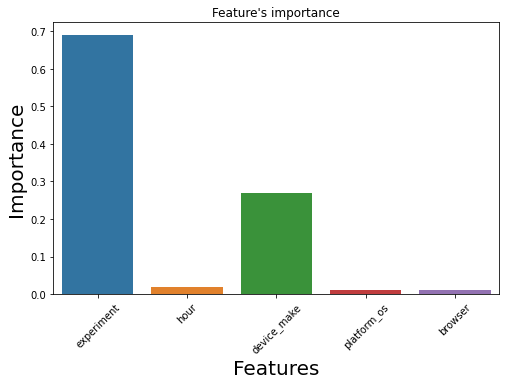

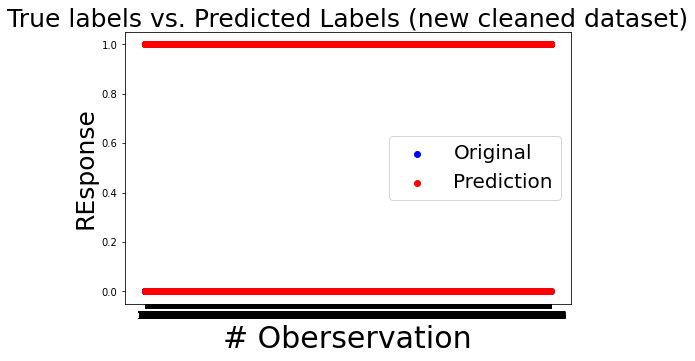

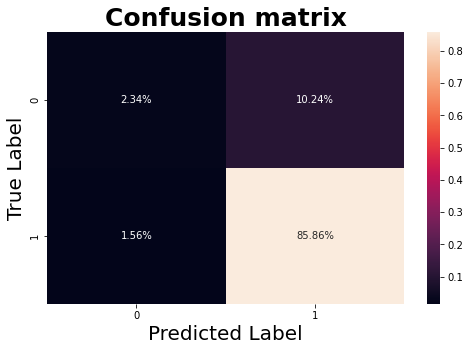

{'accuracy': 0.88, 'precision': 0.89, 'recall': 0.98, 'entropy': 0.32, 'true_pos': 677, 'true_neg': 24888, 'false_pos': 2969, 'false_neg': 452}
{'experiment': 0.69, 'hour': 0.02, 'device_make': 0.27, 'platform_os': 0.01, 'browser': 0.01}
Saving figures


In [25]:
mlflow.end_run()
model = XGBRFClassifier()
run_train_pipeline(model, x, y, 
                experiment_name='new cleaned dataset',
                run_name='XGBRFClassifier on unbalanced data')

mlflow.end_run()